In [15]:
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import sys
sys.path.append('../data')
from modelx import modelx
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import pickle as p
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ========system setting======
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

x_files = {'baike':'token_baike.x', 'regular': 'token.x' ,'gensim': 'token_g.x'}
data_xs = {}
for name, x_f in x_files.items():
    data_xs[name] = p.load(open('../data/'+ x_f, 'rb'))
y = pd.read_csv('../data/call_reason.csv',usecols=['label'])

the aug_cnn/save_baike_0.8325.hdf5 model acc is 0.8324555628703094
 the confusion is 
[[  0   1   2   7]
 [  0   0  86  69]
 [  0  42   0 103]
 [  0  75 124   0]]
the aug_cnn/save_gensim_0.8015.hdf5 model acc is 0.8015141540487163
 the confusion is 
[[  0   0   3   5]
 [  0   0 114  64]
 [  3  99   0 101]
 [  0  96 118   0]]
the aug_cnn/save_regular_0.8015.hdf5 model acc is 0.8015141540487163
 the confusion is 
[[  0   0   0   7]
 [  0   0  90  78]
 [  1 107   0 134]
 [  0  71 115   0]]
the ResNet/save_baike_0.7956.hdf5 model acc is 0.7955892034233049
 the confusion is 
[[  0   0   1  11]
 [  0   0 136  68]
 [  0  59   0 105]
 [  0  80 161   0]]
the ResNet/save_regular_0.7874.hdf5 model acc is 0.7873601053324556
 the confusion is 
[[  0   0   4   8]
 [  0   0  94  77]
 [  0 112   0 122]
 [  0  87 142   0]]
the TcnNet/save_baike_0.7426.hdf5 model acc is 0.7425938117182357
 the confusion is 
[[  0   0   5   7]
 [  0   0 179  19]
 [  0  88   0  92]
 [  0 117 275   0]]
the TcnNet/save_gens

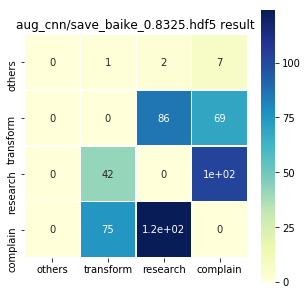

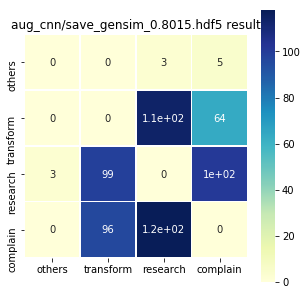

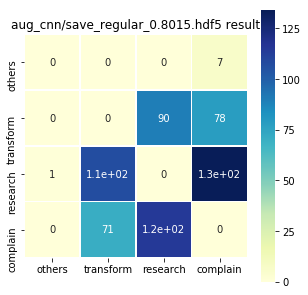

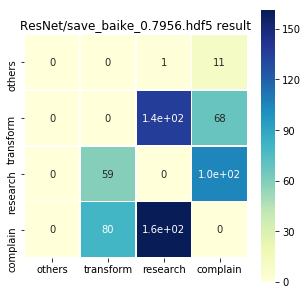

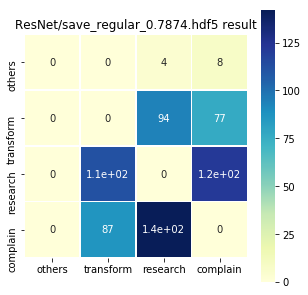

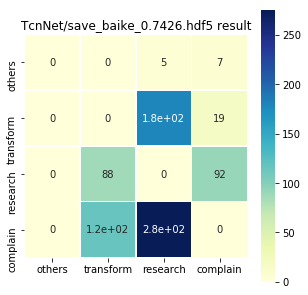

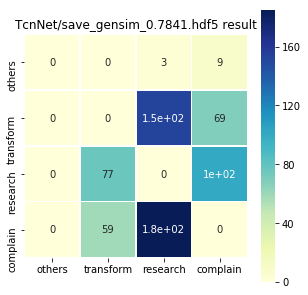

In [16]:
from AttentionWithTopic import *
m_path = './model_file/'
m_files = [
           'aug_cnn/save_baike_0.8325.hdf5',
    'aug_cnn/save_gensim_0.8015.hdf5',
          'aug_cnn/save_regular_0.8015.hdf5',
          'ResNet/save_baike_0.7956.hdf5',
          'ResNet/save_regular_0.7874.hdf5',
          'TcnNet/save_baike_0.7426.hdf5',
'TcnNet/save_gensim_0.7841.hdf5']
for i, model_f in enumerate(m_files):
    if model_f.find('mixNet'):
        model = load_model(m_path+model_f, custom_objects={'Attention': Attention})
    else:
        model = load_model(m_path+model_f)
        
    if model_f.find('regular')!=-1:
        _, test_x, _, test_y = train_test_split(data_xs['regular'].data, y, test_size=0.2, random_state=4)
    elif model_f.find('baike')!=-1:
        _, test_x, _, test_y = train_test_split(data_xs['baike'].data, y, test_size=0.2, random_state=4)
    else:
        _, test_x, _, test_y = train_test_split(data_xs['gensim'].data, y, test_size=0.2, random_state=4)
      
    logist = model.predict(test_x)
    logist = logist.argmax(axis=1)
    cormat = confusion_matrix(test_y, logist)
    for j in range(4):
        cormat[j][j] = 0
    print('the {} model acc is {}\n the confusion is \n{}'.format(model_f, accuracy_score(test_y, logist), cormat))
    f, ax = plt.subplots(figsize=(5, 5))
    ax.set_title(model_f+' result')
    sns.heatmap(cormat, xticklabels = ['others', 'transform', 'research', 'complain'],\
                    yticklabels = ['others', 'transform', 'research', 'complain'],
                square=True, linewidths=.5, annot=True, cmap="YlGnBu")
    

the TcnNet/save_baike_0.7426.hdf5 model acc is 0.8285055957867018
 the confusion is 
[[  0   0   3   9]
 [  0   0  97  55]
 [  0  44   0  95]
 [  0  82 136   0]]


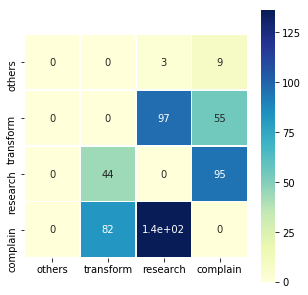

In [8]:
logist = []
for i, model_f in enumerate(m_files):
    model = load_model(m_path+model_f)
    _, test_x, _, test_y = train_test_split(data_xs['baike'].data, y, test_size=0.2, random_state=4)
    logist.append(model.predict(test_x))
logist = np.stack(logist)
logist = np.sum(logist, axis=0)
logist = logist.argmax(axis=1)
cormat = confusion_matrix(test_y, logist)
for j in range(4):
    cormat[j][j] = 0
print('the {} model acc is {}\n the confusion is \n{}'.format(model_f, accuracy_score(test_y, logist), cormat))
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cormat, xticklabels = ['others', 'transform', 'research', 'complain'],\
                yticklabels = ['others', 'transform', 'research', 'complain'],
            square=True, linewidths=.5, annot=True, cmap="YlGnBu")

    
    

In [1]:
from keras.engine import Input
from keras.models import Model
from models import *
import numpy as np
import os
from keras import backend as K

# ========system setting======
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
def get_model(embedding_matrix,
              max_length,
             n_class):
    inputs = Input(shape = (max_length,))
    t_embed = K.constant(np.zeros(shape=(4, 300)))
    embedding_vec = Embedding( input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
        weights= [embedding_matrix],     trainable=False)(inputs)

    logist = lea(embedding_vec, t_embed,  n_class=n_class, l2_a=0)
    model = Model(inputs=inputs, outputs=logist)
    model.summary()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = get_model(np.zeros(shape=(30000,300)), 600, 4)

Using TensorFlow backend.


(?, 600, 4)
(?, 604, 4)
(?, 600)


AttributeError: 'NoneType' object has no attribute '_inbound_nodes'

In [10]:
a = 'some one is here'
a.find('I')

-1

In [4]:
K.transpose(a)

<tf.Tensor 'transpose:0' shape=(4, 3, 2) dtype=float32>